# Capital Assets Pricing Model (CAPM) with Cryptocurrencies

This is just out of curiosity and just for fun, i.e., **this is not financial advice**.

Note that I learned most of the concepts used here from José Portilla's videos in [Python for Financial Analysis and Algorithmic Trading](https://www.udemy.com/course/python-for-finance-and-trading-algorithms/) and Robert Shiller's Coursera course [Financial Markets](https://www.coursera.org/learn/financial-markets-global).

### CAPM in a nutshell

The return or our portfolio $r_p$ is the weighted sum of the returns of each asset in it $r_i$:

$r_p(t) = \sum_{i}^{n} w_i r_i(t)$

The return of each asset $r_i$ can be modelled as a linear regression of its value vs the market return $r_m$:

$r_i(t) = \beta_i r_m(t) + \alpha_i$

Then, the return of our portfolio is also modelled as a multivariate linear regression:

$r_p(t) = \sum_{i}^{n} \beta_i r_m(t) + \sum_{i}^{n} w_i \alpha_i = \beta_p r_m(t) + \sum_{i}^{n} w_i \alpha_i$

Here, the key values are $\alpha$ and $\beta$:
- `beta` is the multiplication/scaling of the market return in our stock; low values indicate lower returns and lower risk (in general, low `betas` are preferable)
- `alpha` is the intercept, i.e., the gains independent from the market behavior. **CAMPM states that `alpha` is random, cannot be predicted and should tend to ZERO; however, commonly that is not followed, instead, investors try to find assets with a high `alpha`! That is what hedge funds do, and apparently it works for them.**

### Hedging

Finding higher `alpha` values means hedging against volatility: the assets with higher returns (with higher risks) are traded off for assets that will yield higher average returns with probably less jumps.

Summary of ways of hedging against risk:
- Assets with high `alpha` and low `beta`
- A diversified portfolio

### Alpha & Beta of BTC & ETH

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats

In [128]:
# Load and prepare datasets
df_global = pd.read_csv('data/Global_Crypto_Marketcap_Statista_Monthly_Formated_2010_2021.csv',header=0)
df_global['Date'] = pd.to_datetime(df_global['Date'])
df_global.set_index('Date',inplace=True)
df_btc = pd.read_csv('data/Bitcoin_Marketcap_Statista_Monthly_Formated_2013_2021.csv',header=0)
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc.set_index('Date',inplace=True)
df_eth = pd.read_csv('data/Ethereum_Marketcap_Statista_Monthly_Formated_2015_2021.csv',header=0)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])
df_eth.set_index('Date',inplace=True)

In [129]:
# Compute maximum possible rane in the data we have
date_start = max(df_global.index[0], df_btc.index[0], df_eth.index[0])
date_end = min(df_global.index[-1], df_btc.index[-1], df_eth.index[-1])

In [130]:
print(date_start,date_end)

2015-08-31 00:00:00 2021-11-30 00:00:00


In [131]:
# Take daily close values
df = pd.DataFrame()
df["Global"] = df_global["Marketcap USD"].loc[date_start:date_end]
df["BTC"] = df_btc["Marketcap USD"].loc[date_start:date_end]
df["ETH"] = df_eth["Marketcap USD"].loc[date_start:date_end]

In [132]:
df.head()

,Global,BTC,ETH
Date,,,
2015-08-31,3.890000e+09,3.350000e+09,100000000.0
2015-09-30,3.990000e+09,3.460000e+09,50000000.0
2015-10-31,4.990000e+09,4.650000e+09,70000000.0
2015-11-30,5.380000e+09,5.620000e+09,70000000.0
2015-12-31,7.010000e+09,6.470000e+09,70000000.0


In [133]:
df.shape

(76, 3)

In [134]:
# Monthly return
df["Global Return"] = df["Global"].pct_change(1)
df["BTC Return"] = df["BTC"].pct_change(1)
df["ETH Return"] = df["ETH"].pct_change(1)

In [135]:
# Compute alpha and beta values with linear regression
result_btc = stats.linregress(x=df['Global Return'].iloc[1:],y=df['BTC Return'].iloc[1:])

In [136]:
# Unpack the result values
# Slope: beta
# Intercept: alpha
beta_btc,alpha_btc,r_value_btc,p_value_btc,std_err_btc = result_btc

In [137]:
# Alpha
# According to CAPM, alpha -> 0
# We see it is not really 0, but it has some residual value
# Even small alpha values can mean a difference:
# that is the return offset we have wrt market
# Beta
# Every market move is scaled with beta to yield our stock moves
print(alpha_btc,beta_btc)

0.02534264096588955 0.616569383344311


In [138]:
print(r_value_btc,p_value_btc)

0.831408606517761 2.6156547436792294e-20


In [139]:
# Compute alpha and beta values with linear regression
result_eth = stats.linregress(x=df['Global Return'].iloc[1:],y=df['ETH Return'].iloc[1:])

In [140]:
# Unpack the result values
beta_eth,alpha_eth,r_value_eth,p_value_eth,std_err_eth = result_eth

In [141]:
print(alpha_eth,beta_eth)

0.08712530277347603 0.9380784699717576


In [142]:
print(r_value_eth,p_value_eth)

0.5734834443939182 7.538385988074451e-08


#### Plots

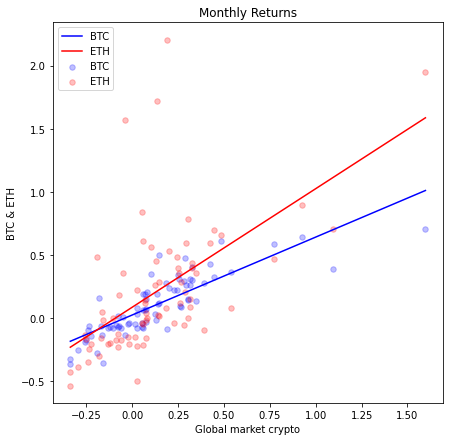

In [143]:
# Plot monthly return: SCATTERPLOT + Regression lines
plt.figure(figsize=(7,7))
# Modelled lines
min_global = df["Global Return"].dropna().values.min()
max_global = df["Global Return"].dropna().values.max()
global_line = np.linspace(min_global,max_global,100)
y_btc = global_line*beta_btc + alpha_btc
y_eth = global_line*beta_eth + alpha_eth
# Plots
plt.scatter(df["Global Return"],df["BTC Return"],alpha=0.25,c='b',s=30)
plt.scatter(df["Global Return"],df["ETH Return"],alpha=0.25,c='r',s=30)
plt.plot(global_line,y_btc,c='blue')
plt.plot(global_line,y_eth,c='red')
plt.xlabel('Global market crypto')
plt.ylabel('BTC & ETH')
plt.legend(['BTC','ETH','BTC','ETH'])
plt.title('Monthly Returns')
plt.show()

We can compute the **hedged return** of an asset = its return minus the modelled beta part applied to the market values.
The hedged return is expected to be less bumpy.

In [144]:
# Hedged BC & ETH returns
df["BTC Return Hedged"] = df["BTC Return"] - df["Global Return"]*beta_btc
df["ETH Return Hedged"] = df["ETH Return"] - df["Global Return"]*beta_eth

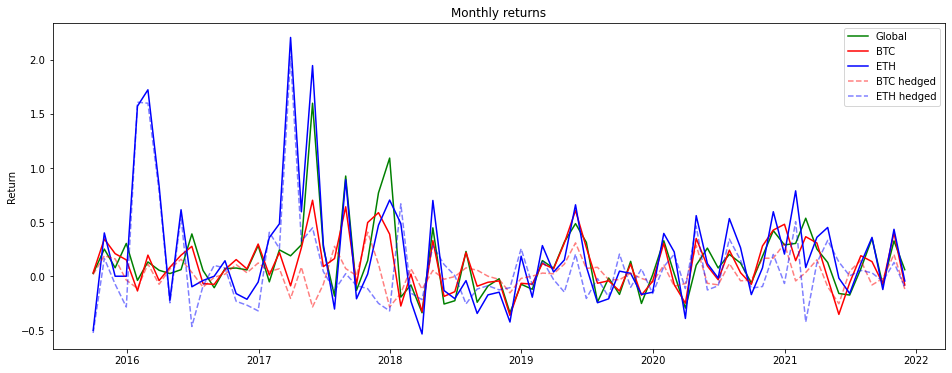

In [145]:
# Plot monthly return: time series with and without beta
plt.figure(figsize=(16,6))
# Modelled lines
min_global = df["Global Return"].dropna().values.min()
max_global = df["Global Return"].dropna().values.max()
global_line = np.linspace(min_global,max_global,100)
y_btc = global_line*beta_btc + alpha_btc
y_eth = global_line*beta_eth + alpha_eth
# Plots
plt.plot(df["Global Return"],c='green')
plt.plot(df["BTC Return"],c='red')
plt.plot(df["ETH Return"],c='blue')
plt.plot(df["BTC Return Hedged"],'r--',alpha=0.5)
plt.plot(df["ETH Return Hedged"],'b--',alpha=0.5)
plt.title('Monthly returns')
plt.ylabel('Return')
plt.legend(['Global','BTC','ETH','BTC hedged','ETH hedged'])
plt.show()

<AxesSubplot:>

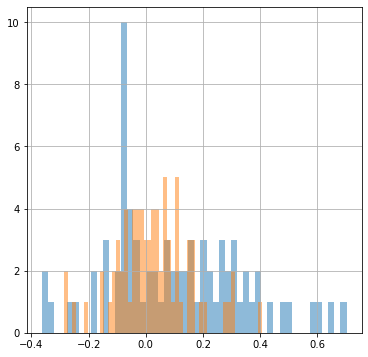

In [146]:
# Histogram of BTC returns: regular vs hedged
df["BTC Return"].hist(bins=50,figsize=(6,6),alpha=0.5)
df["BTC Return Hedged"].hist(bins=50,figsize=(6,6),alpha=0.5)

#### Conclusions

After analysing the monthly data from 2015-08 to 2021-11
- ETH has a higher alpha than BTC, as well as a higher beta
- Recall: the ideal would be a high alpha with a low beta